In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from utilities import load_data_basic_cleanup
from transformers import Trainer, TrainingArguments, DistilBertTokenizerFast, DistilBertForSequenceClassification
from datasets import Dataset, DatasetDict
import torch
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # supress FutureWarning

# Flag to use Saved-Pretrained Model
# Link to pretrained model: https://drive.google.com/drive/folders/1fCoFBVs3e2MSVL8I9qOfv2CQcq54aRnb?usp=sharing
# Please download the entire final_model folder and place it in the root of this project
flag_load_backup = True

model_exists = False
if os.path.exists('./final_model/pytorch_model.bin'):
    model_exists = True
    print("Pretrained Model found")

Pretrained Model found


## Load Data

In [29]:
# Load clean data
df = load_data_basic_cleanup()

In [30]:
# Look at topic distribution
df['TOPIC_MAIN'].value_counts()

TOPIC_MAIN
Nonfiction          31910
Fiction             30686
Children’s Books    19643
Young Adult          3749
Classics             3199
Humor                1450
Poetry               1256
Name: count, dtype: int64

In [31]:
# Ensure data is consistent
print(f"{df['TOPIC_MAIN'].value_counts().sum()} == {df.shape[0]}")

91893 == 91893


In [32]:
# Split dataset into train and test
train_df, test_df = train_test_split(df[['DESCRIPTION', 'TOPIC_MAIN']], test_size=0.2, random_state=42, shuffle=True)

In [33]:
print(train_df.shape) # (73515, 3)
print(test_df.shape) # (18379, 3)

(73514, 2)
(18379, 2)


In [34]:
train_df

,DESCRIPTION,TOPIC_MAIN
63724,"This daring, star-packed collection is the fan...",Fiction
14608,"With her soft heart and angelic face, Madeline...",Fiction
72346,NEW YORK TIMES BESTSELLER * A deeply affecting...,Nonfiction
12024,"ONE CHILL EVENING IN BETHLEHEM, young Naomi he...",Children’s Books
16203,All original stories about the return of Cthul...,Fiction
...,...,...
6265,"Following a wild and raging storm, the Swiss f...",Children’s Books
54886,A family-focused guidebook to Italy for travel...,Nonfiction
76820,A single volume of the most beautiful texts by...,Poetry
860,The Truth Chasers Book Three. Someone's trying...,Fiction


In [35]:
test_df

,DESCRIPTION,TOPIC_MAIN
62081,This lexicon of modern Western philosophical c...,Nonfiction
18176,"Emily-and her new band, the Strangers-won the ...",Children’s Books
19140,A perfect graudation gift all about growing up...,Children’s Books
16534,Even a bookish big sister is drawn in by the p...,Children’s Books
21974,Where Can You Find the Kind of Love You Truly ...,Nonfiction
...,...,...
458,"In a small, dusty town in India, Sripathi Rao ...",Fiction
25026,The Limits to Capital provides one of the best...,Nonfiction
73035,How climate change will affect our political t...,Nonfiction
43431,When a woman's body washes up on the shore of ...,Fiction


In [36]:
# Convert categorical labels (topics) to numerical values
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['TOPIC_MAIN'])
test_df['label'] = label_encoder.transform(test_df['TOPIC_MAIN'])
train_df.head()

,DESCRIPTION,TOPIC_MAIN,label
63724,"This daring, star-packed collection is the fan...",Fiction,2
14608,"With her soft heart and angelic face, Madeline...",Fiction,2
72346,NEW YORK TIMES BESTSELLER * A deeply affecting...,Nonfiction,4
12024,"ONE CHILL EVENING IN BETHLEHEM, young Naomi he...",Children’s Books,0
16203,All original stories about the return of Cthul...,Fiction,2


In [37]:
if not (flag_load_backup and model_exists):
    # Convert Pandas DataFrames to HuggingFace Dataset-format
    dataset = DatasetDict({
        'train': Dataset.from_pandas(train_df[['DESCRIPTION', 'label']]),
        'test': Dataset.from_pandas(test_df[['DESCRIPTION', 'label']])
    })
    print(dataset)

DatasetDict({
    train: Dataset({
        features: ['DESCRIPTION', 'label', '__index_level_0__'],
        num_rows: 73514
    })
    test: Dataset({
        features: ['DESCRIPTION', 'label', '__index_level_0__'],
        num_rows: 18379
    })
})


## Tokenize data

In [38]:
if not (flag_load_backup and model_exists):
    # Load pre-trained DistilBERT tokenizer
    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

    def tokenize(batch):
        texts = [str(text) if text is not None else "" for text in batch['DESCRIPTION']]
        # tokenize text with padding and truncate for consistent input length
        return tokenizer(texts, padding="max_length", truncation=True)

    # Apply function to the dataset
    dataset = dataset.map(tokenize, batched=True)

    # Remove 'DESCRIPTION' column, as it's not needed after tokenization
    dataset = dataset.remove_columns(['DESCRIPTION'])

    # Set the format of the dataset to PyTorch tensors
    dataset.set_format("torch")

## Setup Model Training

In [39]:
if not (flag_load_backup and model_exists):
    # Check GPU availability
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
    else:
        print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 4070 Ti is available.


In [40]:
if not (flag_load_backup and model_exists):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device) # cuda == GPU usage

cuda


## Train model

In [41]:
if not (flag_load_backup and model_exists):
    # Load the pre-trained DistilBERT model for sequence classification
    # + specify num_labels (number of unique topics)
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))

    training_args = TrainingArguments(
        output_dir="./results", # directory where model/checkpoints are saved
        evaluation_strategy="epoch", # evaluate at the end of epoch
        save_strategy="epoch", # save model each epoch
        learning_rate=2e-5,
        per_device_train_batch_size=16, # consumes about 7GB of VRAM
        per_device_eval_batch_size=16,
        num_train_epochs=2, # 2 training epochs
        weight_decay=0.01, # weight decay to prevent overfitting
        logging_dir="./logs",
        logging_steps=10, # log each ten steps
        no_cuda=False, # force gpu usage
        fp16=True, # mixed precision to speed up training
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
    )

    # Start training the model
    trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.we

Epoch,Training Loss,Validation Loss
1,0.280900,0.252577
2,0.116800,0.266864


## Evaluate model

In [42]:
if not (flag_load_backup and model_exists):
    # Evaluate model on test set
    trainer.evaluate()

In [43]:
if not (flag_load_backup and model_exists):
    # Generate predictions on the test set
    predictions = trainer.predict(dataset["test"])

    # Extract the predictions and labels
    preds = predictions.predictions.argmax(-1)  # Get predicted class labels
    labels = predictions.label_ids # Get true labels

In [44]:
if not (flag_load_backup and model_exists):
    # Generate classification report
    report = classification_report(labels, preds, target_names=label_encoder.classes_)  # Ensure label names are included
    accuracy = accuracy_score(labels, preds)


    print("Classification Report - DistillBert:\n")
    print(report)
    print(f"Accuracy: {accuracy:.4f}")
    print("Macro F1-Score:", f1_score(labels, preds, average='macro'))

Classification Report - DistillBert:

                  precision    recall  f1-score   support

Children’s Books       0.92      0.96      0.93      3912
        Classics       0.81      0.71      0.75       648
         Fiction       0.95      0.95      0.95      6096
           Humor       0.71      0.52      0.60       272
      Nonfiction       0.95      0.96      0.96      6426
          Poetry       0.87      0.87      0.87       243
     Young Adult       0.76      0.66      0.70       782

        accuracy                           0.93     18379
       macro avg       0.85      0.80      0.82     18379
    weighted avg       0.92      0.93      0.92     18379

Accuracy: 0.9257
Macro F1-Score: 0.8233861552385638


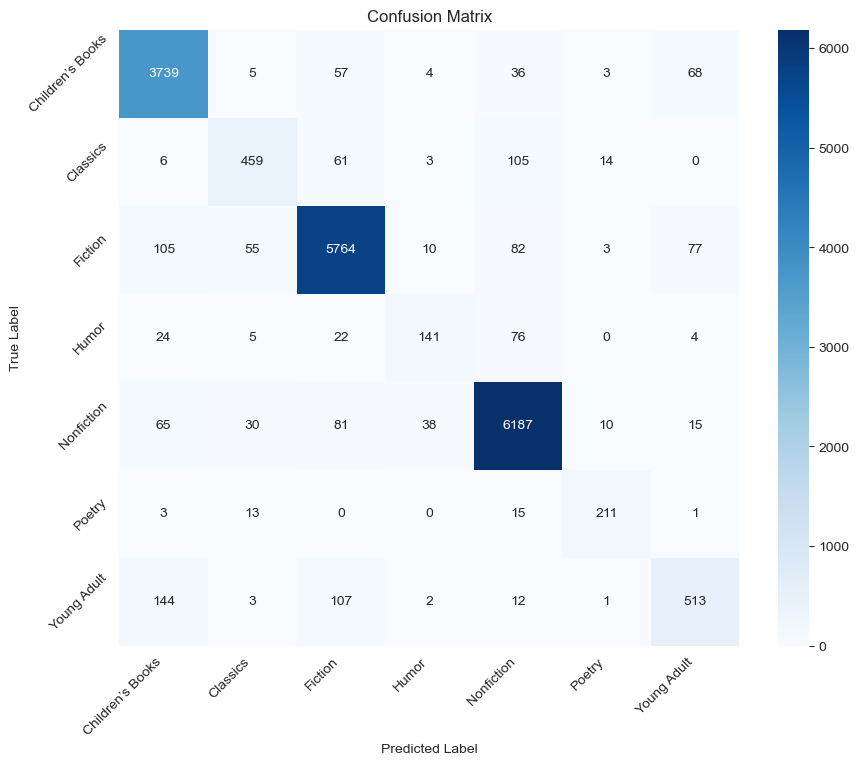

In [45]:
if not (flag_load_backup and model_exists):
    # Generate + Visualize ConfusionMatrix
    cm = confusion_matrix(labels, preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=45)
    plt.show()

In [46]:
if not (flag_load_backup and model_exists):
    # Save final model
    model.save_pretrained("./final_model")
    tokenizer.save_pretrained("./final_model")

## Test trained model

In [47]:
# Load saved model
saved_model = DistilBertForSequenceClassification.from_pretrained("./final_model", num_labels=len(label_encoder.classes_))

# Load saved tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("./final_model")

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to chosen device (GPU or CPU)
saved_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [48]:
def predict_top_3(description):
    # Tokenize the input description
    inputs = tokenizer(description, padding=True, truncation=True, return_tensors="pt")

    # Move inputs to the device (GPU or CPU)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the model's logits (raw prediction scores)
    with torch.no_grad():
        logits = saved_model(**inputs).logits

    # Get the top 3 predictions based on the logits (softmax to get probabilities)
    probs = torch.nn.functional.softmax(logits, dim=-1)

    # Get top 3 predictions
    top_3_values, top_3_indices = torch.topk(probs, 3, dim=-1)

    # Convert to numpy and get the predicted labels
    top_3_values = top_3_values.cpu().numpy().flatten()  # Get probabilities
    top_3_indices = top_3_indices.cpu().numpy().flatten()  # Get indices of the topics

    top_3_topics = label_encoder.inverse_transform(top_3_indices)

    return list(zip(top_3_topics, top_3_values))

## Test model prediction

In [49]:
new_description = "A thrilling adventure about a young hero discovering magic."
predicted_top_3 = predict_top_3(new_description)

print("Topics (Sorted according to similarities):")
for topic, prob in predicted_top_3:
    print(f"{topic}: {prob:.4f} %")

Topics (Sorted according to similarities):
Children’s Books: 0.9965 %
Young Adult: 0.0023 %
Fiction: 0.0006 %


In [50]:
new_description = "A thrilling adventure about a hero discovering magic."
predicted_top_3 = predict_top_3(new_description)

print("Topics (Sorted according to similarities):")
for topic, prob in predicted_top_3:
    print(f"{topic}: {prob:.4f} %")

Topics (Sorted according to similarities):
Children’s Books: 0.9969 %
Young Adult: 0.0020 %
Fiction: 0.0006 %


In [51]:
new_description = "A thrilling adventure about a hero discovering America."
predicted_top_3 = predict_top_3(new_description)

print("Topics (Sorted according to similarities):")
for topic, prob in predicted_top_3:
    print(f"{topic}: {prob:.4f} %")

Topics (Sorted according to similarities):
Children’s Books: 0.9878 %
Young Adult: 0.0087 %
Fiction: 0.0023 %


In [52]:
new_description = "A story about America."
predicted_top_3 = predict_top_3(new_description)

print("Topics (Sorted according to similarities):")
for topic, prob in predicted_top_3:
    print(f"{topic}: {prob:.4f} %")

Topics (Sorted according to similarities):
Fiction: 0.4837 %
Children’s Books: 0.3043 %
Young Adult: 0.1766 %
